## Introduction

This notebook is designed to train PrePR-CT and reproduce the results using the Nault dataset. Before running the notebook, please ensure you have set the correct paths for the input and output files:

- **Data Path**: The location of the dataset files.
- **Results Path**: The directory where the output results will be saved.
- **Models Path**: The directory to save model checkpoints.
- **parent_dir**: The location of the cell type graphs

```python
data_path = "Cell-Type-Specific-Graphs/Data/"
save_path_results = "Cell-Type-Specific-Graphs/Results/"
save_path_models = "Cell-Type-Specific-Graphs/model_checkpoints/"
parent_dir = "Cell-Type-Specific-Graphs/graphs/"

In [1]:
import torch
print(torch.__version__)
import pandas as pd
import os
import scanpy as sc 
import sys
import numpy as np
import gzip
import matplotlib.pyplot as pl
from statistics import mode
from numpy.random import RandomState
import re
import seaborn as sns
import pickle
from scipy.io import mmread
from scipy.sparse import csr_matrix
from sklearn import preprocessing
from torch_geometric.data import Data, DataLoader
from torch_geometric.utils import *
import tqdm.notebook as tq
import shutil
import sys 
sys.path.insert(0, '../')
import utils
from importlib import reload
reload(utils)
from utils import *
import model
from importlib import reload
reload(model)
from model import *

data_path = "Cell-Type-Specific-Graphs/Data/"
save_path_results = "Cell-Type-Specific-Graphs/Results/"
save_path_models = "Cell-Type-Specific-Graphs/model_checkpoints/"

1.13.1+cu117


2024-11-06 15:07:34.802345: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
2024-11-06 15:07:39.236557: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
/home/alsulara/miniconda3/envs/Perturbation_Project/lib/python3.8/site-packages/ot/backend.py:2998: UserWarning: To use TensorflowBackend, you need to activate the tensorflow numpy API. You can activate it by running: 
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()
  register_backend(TensorflowBackend())


## Import Data

In [2]:
adata = sc.read(data_path+'Nault.h5ad')
print(len(adata.obs.loc[adata.obs.condition == 'control']), len(adata.obs.loc[adata.obs.condition != 'control']))
print(len(adata.obs.loc[adata.obs.condition == 'control']) + len(adata.obs.loc[adata.obs.condition != 'control']))
adata

12452 6282
18734


AnnData object with n_obs × n_vars = 18734 × 5000
    obs: 'Dose', 'batch', 'cell_type', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'n_counts', 'condition', 'drug_dose_name', 'cov_drug_dose_name', 'cov_drug', 'condition_label', 'SEACell'
    var: 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'cell_type_colors', 'celltype_colors', 'condition_colors', 'hvg', 'log1p', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

## Import the Cell Type Graphs in a Dictionary Form

In [3]:
cell_type_network = {}
# Leaf directory 
directory = "Nault"
# Parent Directories 
parent_dir = "Cell-Type-Specific-Graphs/graphs/"
# Path 
path = os.path.join(parent_dir, directory)
print(path)
try: 
    os.makedirs(path) 
except:
    print("File exists!")
max_nodes = 0
genes_pos = []
for cell_type in adata.obs.cell_type.unique():
    print(cell_type)
    cell_type_network[cell_type] = torch.load(os.path.join(path,cell_type+'_coexpr_graph.pkl'))
    if cell_type_network[cell_type].num_nodes >= max_nodes:
        max_nodes = cell_type_network[cell_type].num_nodes
print(max_nodes)
cell_type_network    ## 

/ibex/scratch/alsulara/Cell-Type-Specific-Graphs/graphs/Nault
File exists!
Stellate Cells
Hepatocytes - portal
Endothelial Cells
Cholangiocytes
Hepatocytes - central
Portal Fibroblasts
3771


{'Stellate Cells': Data(x=[2976, 26], edge_index=[2, 245338], edge_attr=[245338], pos=[2976]),
 'Hepatocytes - portal': Data(x=[1535, 128], edge_index=[2, 245064], edge_attr=[245064], pos=[1535]),
 'Endothelial Cells': Data(x=[3084, 32], edge_index=[2, 245192], edge_attr=[245192], pos=[3084]),
 'Cholangiocytes': Data(x=[3771, 7], edge_index=[2, 246267], edge_attr=[246267], pos=[3771]),
 'Hepatocytes - central': Data(x=[2614, 50], edge_index=[2, 245236], edge_attr=[245236], pos=[2614]),
 'Portal Fibroblasts': Data(x=[3561, 6], edge_index=[2, 246460], edge_attr=[246460], pos=[3561])}

## ## Compute DEGs per cell type and drug

In [4]:
adata.uns['gene_network'] = {}
adata.uns['rank_genes_groups_cov_DEGs'] = {}
for cell_type in adata.obs.cov_drug.unique():
    if cell_type.split('_')[1] != 'control':
        adata_cov = adata[adata.obs.cell_type == cell_type.split('_')[0], cell_type_network[cell_type.split('_')[0]].pos.tolist()].copy()
        adata_cov.uns['log1p']['base'] = None
        sc.tl.rank_genes_groups(adata_cov, groupby = 'cov_drug',rankby_abs = True,
                                        reference = cell_type.split('_')[0]+'_control',n_genes = len(adata_cov.var))
        dedf = sc.get.rank_genes_groups_df(adata_cov, group=cell_type)
        dedf = dedf.loc[dedf['pvals_adj'] < 0.05].copy()
        DEGs_name = rank_genes(dedf)
        df = adata_cov.var.reset_index()
        adata.uns['gene_network'][cell_type] = df.index.values
        adata.uns['rank_genes_groups_cov_DEGs'][cell_type] = DEGs_name
        pd.DataFrame(DEGs_name).to_csv(save_path_results+"Nault_"+cell_type+"_DEGs_name.csv")
        pd.DataFrame(adata_cov.var.index.values).to_csv(save_path_results+"Nault_"+cell_type+"_all_genes.csv")

## Split the data

In [5]:
testing_cell = 'Hepatocytes - portal'
testing_drugs = ['TCDD']
adata.obs["dose_value"] = 1.0
adata.obs['cov_drug'] = adata.obs.cell_type.astype(str) + '_' + adata.obs.condition.astype(str)
label_encoder = preprocessing.LabelEncoder()
adata.obs["condition_label"] = label_encoder.fit_transform(adata.obs["condition"])
num_perts = adata.obs["condition_label"].max()+1
adata.obs['split'] = 'train'
adata.obs.loc[(adata.obs.cell_type == testing_cell) & (adata.obs["condition"].isin(testing_drugs)), 'split'] = 'ood'
valid_idx = sc.pp.subsample(adata[(adata.obs['split'] != "ood") & (adata.obs['condition'] != "control")], 0.10, copy=True, random_state = 42).obs.index
adata.obs["split"].loc[valid_idx] = "valid"
display(adata.obs.split.value_counts())

/tmp/ipykernel_754013/495958876.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata.obs["split"].loc[valid_idx] = "valid"


split
train    17156
ood       1056
valid      522
Name: count, dtype: int64

## Match Control to Treatment Cells

In [6]:
stim_data = adata[adata.obs.condition != 'control'].copy()
stim_data.layers['ctrl_x'] = stim_data.X.A
ctrl_data = adata[adata.obs.condition == 'control'].copy()

for cell_type in adata.obs.cell_type.unique():
    genes = cell_type_network[cell_type].pos.tolist()
    cell_type_network[cell_type].x = torch.mean(torch.tensor(ctrl_data[ctrl_data.obs.cell_type == cell_type, genes].copy().X.A), dim = 0)
    std = torch.var(torch.tensor(ctrl_data[ctrl_data.obs.cell_type == cell_type, genes].copy().X.A), dim = 0)
    cell_type_network[cell_type].x = torch.cat([cell_type_network[cell_type].x.unsqueeze(1), std.unsqueeze(1)], dim = 1)    


for cov_drug in stim_data.obs.cov_drug.unique():
    cell_type = cov_drug.split('_')[0]

    ad_ctrl = ctrl_data[ctrl_data.obs.cell_type == cell_type].copy()
    ad_stim = stim_data[stim_data.obs.cov_drug == cov_drug].copy()
    num_samples = len(ad_stim)
    sele_samples = balance_subsample(np.array(ad_ctrl.obs.index.values.tolist()), np.array(ad_ctrl.obs.SEACell.values.tolist()), num_samples)
    stim_data[ ad_stim.obs.index.values,: ].layers['ctrl_x'] = ad_ctrl[sele_samples, :].copy().X.A

/home/alsulara/miniconda3/envs/Perturbation_Project/lib/python3.8/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/alsulara/miniconda3/envs/Perturbation_Project/lib/python3.8/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/alsulara/miniconda3/envs/Perturbation_Project/lib/python3.8/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/alsulara/miniconda3/envs/Perturbation_Project/lib/python3.8/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/alsula

## Save the data in a form of PyG Data objects to train GNN

In [9]:
# cells_train = create_cells(stim_data[stim_data.obs.split == 'train'].copy(),cell_type_network, None)
# cells_valid = create_cells(stim_data[stim_data.obs.split == 'valid'].copy(),cell_type_network, None)
# cells_ood = create_cells(stim_data[stim_data.obs.split == 'ood'].copy(),cell_type_network, None)

# with open(data_path+'cells_train_Nault.pkl', 'wb') as f:
#     pickle.dump(cells_train, f)
# with open(data_path+'cells_valid_Nault.pkl', 'wb') as f:
#     pickle.dump(cells_valid, f)
# with open(data_path+'cells_ood_Nault.pkl', 'wb') as f:
#     pickle.dump(cells_ood, f)

In [10]:
with open(data_path+'cells_train_Nault.pkl', 'rb') as pickle_file:
    cells_train = pickle.load(pickle_file)

with open(data_path+'cells_valid_Nault.pkl', 'rb') as pickle_file:
    cells_valid = pickle.load(pickle_file)
# 
with open(data_path+'cells_ood_Nault.pkl', 'rb') as pickle_file:
    cells_ood = pickle.load(pickle_file)
    
print(len(cells_train), len(cells_valid), len(cells_ood))

4704 522 1056


/home/alsulara/miniconda3/envs/Perturbation_Project/lib/python3.8/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

R2 top 20 DEGs:  0.9907586724069171
R2 top 50 DEGs:  0.9689681015232818
R2 all genes:  0.9667775939836932
R2 top 100 DEGs:  0.9693685889235173
1535


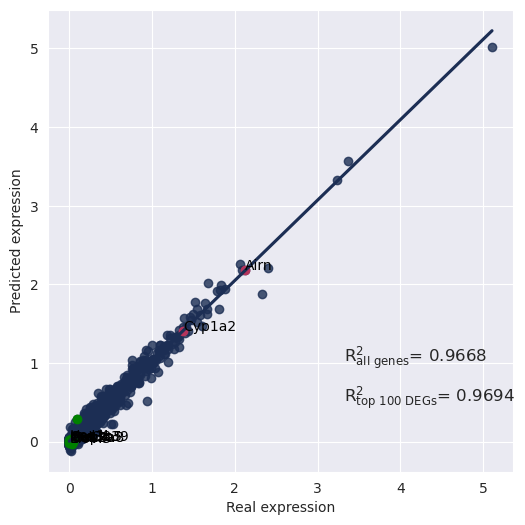

/home/alsulara/miniconda3/envs/Perturbation_Project/lib/python3.8/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/alsulara/miniconda3/envs/Perturbation_Project/lib/python3.8/site-packages/scanpy/plotting/_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


<Figure size 640x480 with 0 Axes>

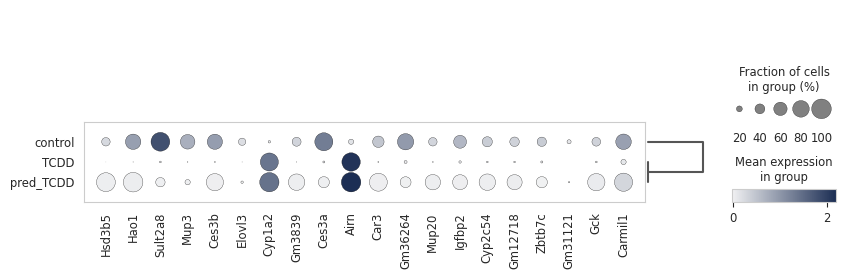

/home/alsulara/miniconda3/envs/Perturbation_Project/lib/python3.8/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


  0%|          | 0/5 [00:00<?, ?it/s]

R2 top 20 DEGs:  0.7405414488703561
R2 top 50 DEGs:  0.512781810876886
R2 all genes:  0.5007357421923093
R2 top 100 DEGs:  0.6390876360292576
1535


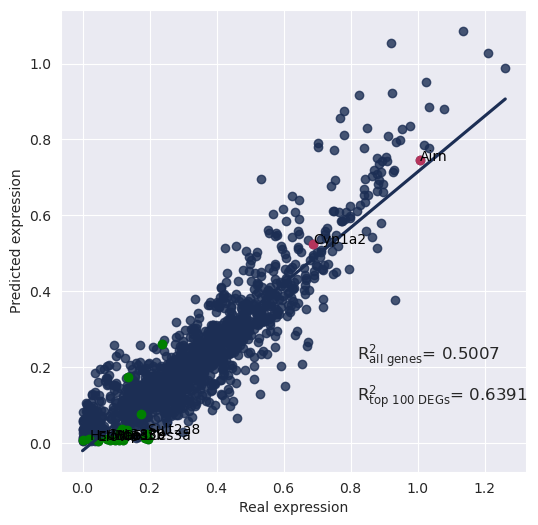

/home/alsulara/miniconda3/envs/Perturbation_Project/lib/python3.8/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/alsulara/miniconda3/envs/Perturbation_Project/lib/python3.8/site-packages/scanpy/plotting/_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


<Figure size 640x480 with 0 Axes>

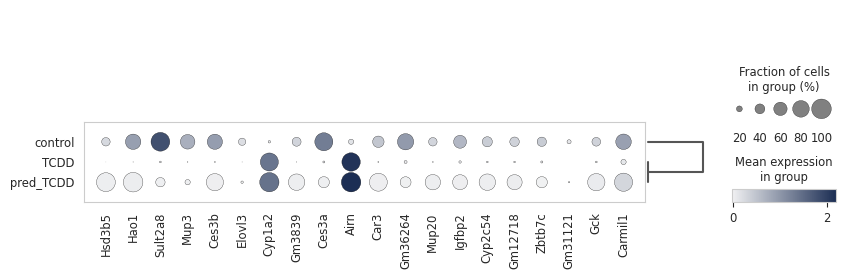

/home/alsulara/miniconda3/envs/Perturbation_Project/lib/python3.8/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [17]:
from importlib import reload
import utils
reload(utils)
from utils import *
import model
from importlib import reload
reload(model)
from model import *
import optuna

testing_drug = 'TCDD'
torch.manual_seed(42) 
params = {'hidden_channels': 64, 'weight_decay': 1e-05, 'in_head': 4, 'learning_rate': -3, 'num_epochs': 200, 'batch_size': 256}  
train_dataloader = DataLoader(cells_train+cells_valid, batch_size=params['batch_size'], shuffle=True)
model = GNN(total_genes  = len(adata.var), num_perts = num_perts, act_fct = 'Softplus', 
            hidden_channels = params['hidden_channels'], in_head = params['in_head']).to(device)
# model = train(model = model
#                   ,num_epochs = params['num_epochs'], lr = 10**params['learning_rate'],
#                   weight_decay = params['weight_decay'], cell_type_network = cell_type_network, train_loader = train_dataloader, multi_pert = False)
# torch.save(model.state_dict(), save_path_models+"Nault_model.pt")
model.load_state_dict(torch.load(save_path_models+"Nault_model.pt"))
r2_all_avg = []
r2_degs_avg = []
r2_all_std = []
r2_degs_std = []
pred_adata = []
ood_loader_all = DataLoader(cells_ood, batch_size=len(cells_ood), shuffle=False)
oods_cells = np.array(next(iter(ood_loader_all)).cell_type)
for ood_cells in tq.tqdm(set(oods_cells)):
    index_cell_type = np.where(oods_cells == ood_cells)[0]
    data_ood = [cells_ood[i] for i in index_cell_type]
    ood_loader_cell_type = DataLoader(data_ood, batch_size=256, shuffle=False)
    r2_all, r2_DEGs, DEGs_name, dot_adata = Inference(cell_type_network, model, 
               save_path_results+"Nault_mean_"+testing_drug, ood_loader_cell_type, 
               ood_cells, adata, testing_drug = testing_drug, 
               degs_dict = adata.uns['rank_genes_groups_cov_DEGs'][ood_cells+'_'+testing_drug], mean_or_std = True, plot = True, multi_pert = False)
    r2_all_avg.append(r2_all)
    r2_degs_avg.append(r2_DEGs)
    #---------------------------------------------------------------------------------------------------------
    r2_all, r2_DEGs, DEGs_name, dot_adata = Inference(cell_type_network, model, 
               save_path_results+"Nault_std_"+testing_drug, ood_loader_cell_type, 
               ood_cells, adata, testing_drug = testing_drug, 
               degs_dict = adata.uns['rank_genes_groups_cov_DEGs'][ood_cells+'_'+testing_drug], mean_or_std = False, plot = True, multi_pert = False)
    r2_all_std.append(r2_all)
    r2_degs_std.append(r2_DEGs)
    pred_adata.append(dot_adata)
pred_adata.append(adata[adata.obs.cov_drug == testing_cell+'_control', cell_type_network[testing_cell].pos.tolist()].copy())

## Visualize the UMAP of Observed and Predicted Expression


/home/alsulara/miniconda3/envs/Perturbation_Project/lib/python3.8/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/alsulara/miniconda3/envs/Perturbation_Project/lib/python3.8/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/alsulara/miniconda3/envs/Perturbation_Project/lib/python3.8/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False,

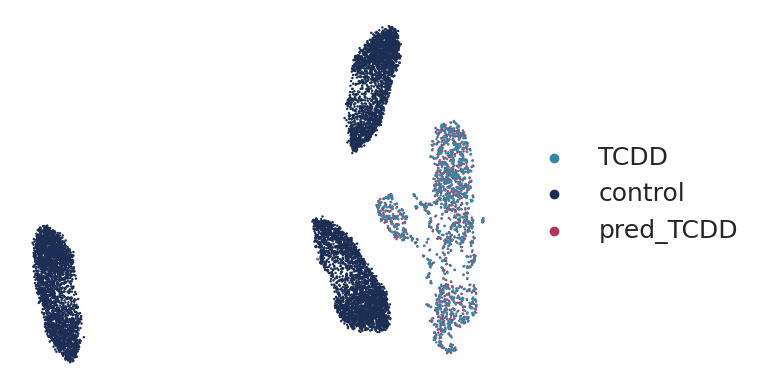

In [11]:
pred_adata_all = sc.concat(pred_adata, join='outer')

pred_adata_all.obs['Condition'] = 'TCDD'
pred_adata_all.obs.loc[pred_adata_all.obs.condition == 'control','Condition'] = 'control'
pred_adata_all.obs.loc[pred_adata_all.obs['condition'].str.startswith('pred'), 'Condition'] = 'pred_TCDD'
pred_adata_all.obs.rename(columns={'Condition': 'Treatment'}, inplace=True) 

sc.pp.neighbors(pred_adata_all)
sc.tl.umap(pred_adata_all) 
fig, ax = plt.subplots()
custom_colors = {'TCDD':'#3487A7' , 'control': '#1C2E54', 'pred_TCDD': '#B5345C'}
sc.pl.umap(pred_adata_all, color='Treatment',  ax=ax, show=False, palette=list(custom_colors.values()), frameon=False, legend_fontsize=18)
# Remove the box (spines) around the plot
plt.savefig(save_path_results+"UMAP_Pred_Nault.pdf", bbox_inches='tight')
ax.set_title('')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)